# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [ ]:
# import my bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf
from walkforward_validation import walk_forward_val, series_to_supervised

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

# general data wrangling and visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate



# 1. Fourier methods

In [ ]:
financial_assets = ['CrudeOil']#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_fourier'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = automatic_fourier_denoising(signal,df, split,verbose=False)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    # blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_modesl,
                'MLP':blah.mlp_model,
                'LSTM':blah.lstm_model}

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None,
                'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
                                                                                    original_series = walk_forward_input,
                                                                                    time_series_dates=df['Date'].iloc[-2000:],
                                                                                    lag_window_length=window_length,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_fourier_denoising_wf,
                                                                                    only_training=True,
                                                                                    verbose=False,
                                                                                    threshold_override=False,
                                                                                    threshold=0.05
                                                                                    )
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')



# 2. Wavelet methods

In [ ]:
financial_assets = ['CrudeOil'] #,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_wavelet'
column_to_predict = 'Close' #'#Passengers' 


for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = automatic_wavelet_denoising(signal,df, split,
                                                    verbose=True,
                                                    wavelet='sym8',
                                                    threshold_override=False, 
                                                    threshold=0.4)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    # blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model#,
                # 'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None#,
                # 'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,model,
                                                                                    original_series = walk_forward_input,
                                                                                    time_series_dates = df['Date'].iloc[-2000:],
                                                                                    lag_window_length=window_length,
                                                                                    train_len=train_len,
                                                                                    test_len=test_len,
                                                                                    train_frequency=10,
                                                                                    transformer=automatic_wavelet_denoising_wf,
                                                                                    only_training=True,
                                                                                    verbose=False,
                                                                                    wavelet='sym8',
                                                                                    threshold_override=True,
                                                                                    threshold=0.9)
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')


# 3. Moving averages

In [ ]:
# moving average function for feature engineering during walk forward validation
def moving_average_wf(signal,moving_average):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.rolling(moving_average,min_periods=1).mean().to_numpy()

    return series_smooth
    

In [ ]:
import copy

financial_assets = ['CrudeOil']#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_moving_average'
column_to_predict = 'Close' #'#Passengers' 


for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # smoothen data
    moving_average = 15
    signal = copy.deepcopy(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = signal.rolling(moving_average,min_periods=1).mean().to_numpy()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
    ax.plot(df['Date'][:-split], denoised_signal,label=f"MA_{moving_average}")
    max = df.iloc[:-split,:].shape[0]
    relevant_dates = df['Date'][:-split]
    ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
    plt.legend()
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    # blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model#,
                # 'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None#,
                # 'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                            model=model,
                                                                            original_series = walk_forward_input,
                                                                            time_series_dates = df[f'Date'].iloc[-2000:],
                                                                            lag_window_length= 10,
                                                                            train_len=225,
                                                                            test_len=25,
                                                                            train_frequency=10,
                                                                            transformer=moving_average_wf,
                                                                            only_training=False,
                                                                            moving_average=moving_average,
                                                                            )
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')


# 4. Exponentially weighted moving average

In [7]:
# moving average function for feature engineering during walk forward validation
def ewma_wf(signal,alpha):
    # numpy array to pandas series
    series = pd.Series(signal)

    # smoothen
    series_smooth = series.ewm(alpha=alpha).mean().to_numpy()

    return series_smooth
    

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


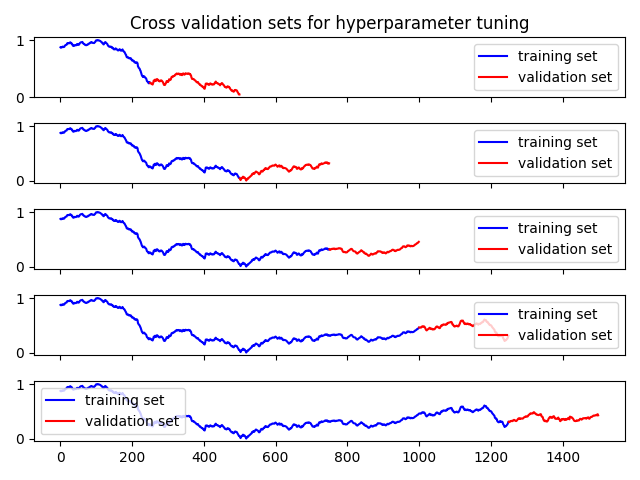

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.00228937 -0.01873972  0.01717884 -0.00279716 -0.03366426 -0.00388942
  0.07485845 -0.10758018 -0.33047558  1.40088413]
MAPE: 0.1227183209380718
RMSE:  0.02469922407543756
MAE:  0.015018679531063048

Training support vector machine:
Model params:  {'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 0.309833452940101
RMSE:  0.048352454942742484
MAE:  0.03465706310199855

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_stat

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.8 %
Confusion matrix:
[[490 344]
 [547 394]]
MAPE: 1.0114281626303037
RMSE:  0.17028122392341954
MAE:  0.14581092011545657
Directional Accuracy:  0.49802816901408453


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 51.55 %
Confusion matrix:
[[400 434]
 [426 515]]
MAPE: 0.2718391944868688
RMSE:  0.05391461207381734
MAE:  0.04029586698608237
Directional Accuracy:  0.5154929577464789


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


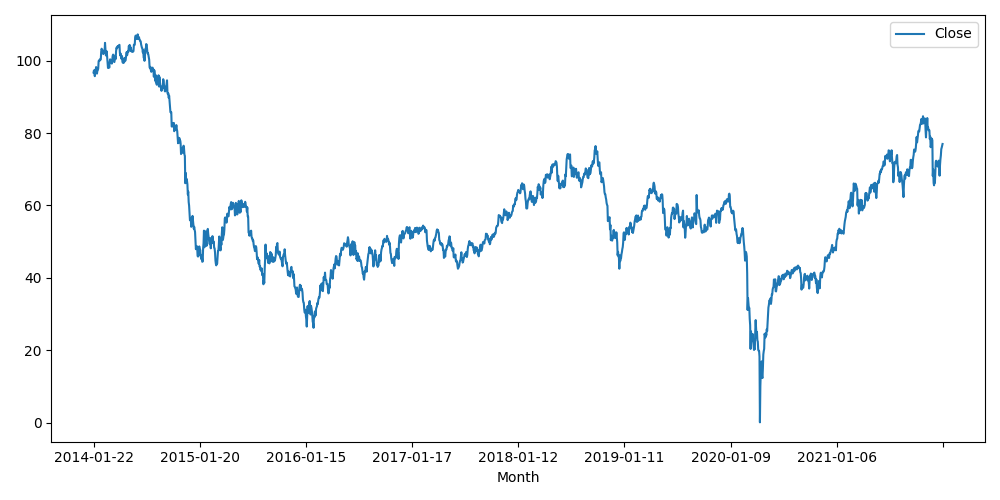

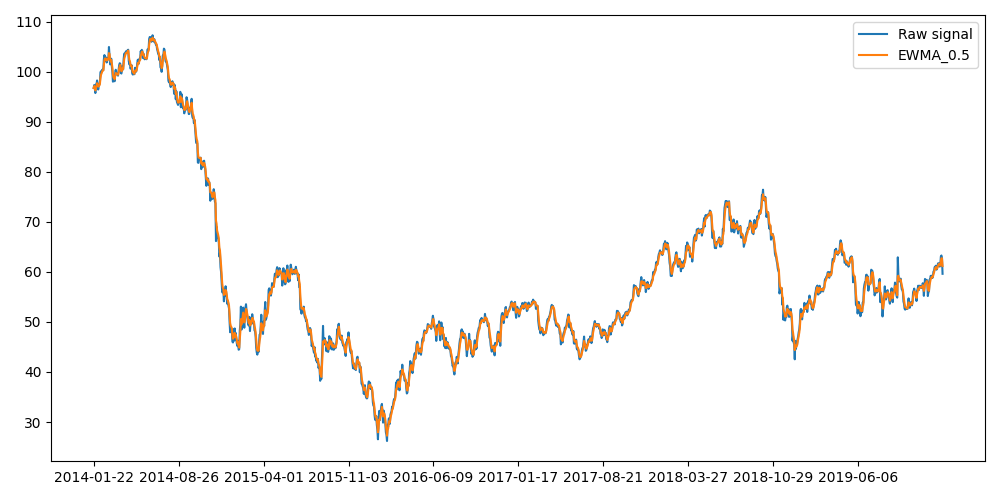

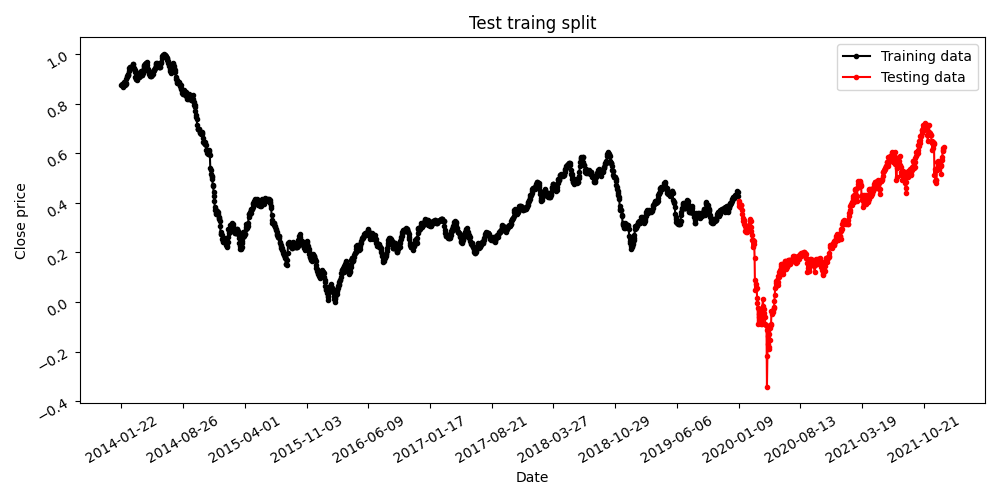

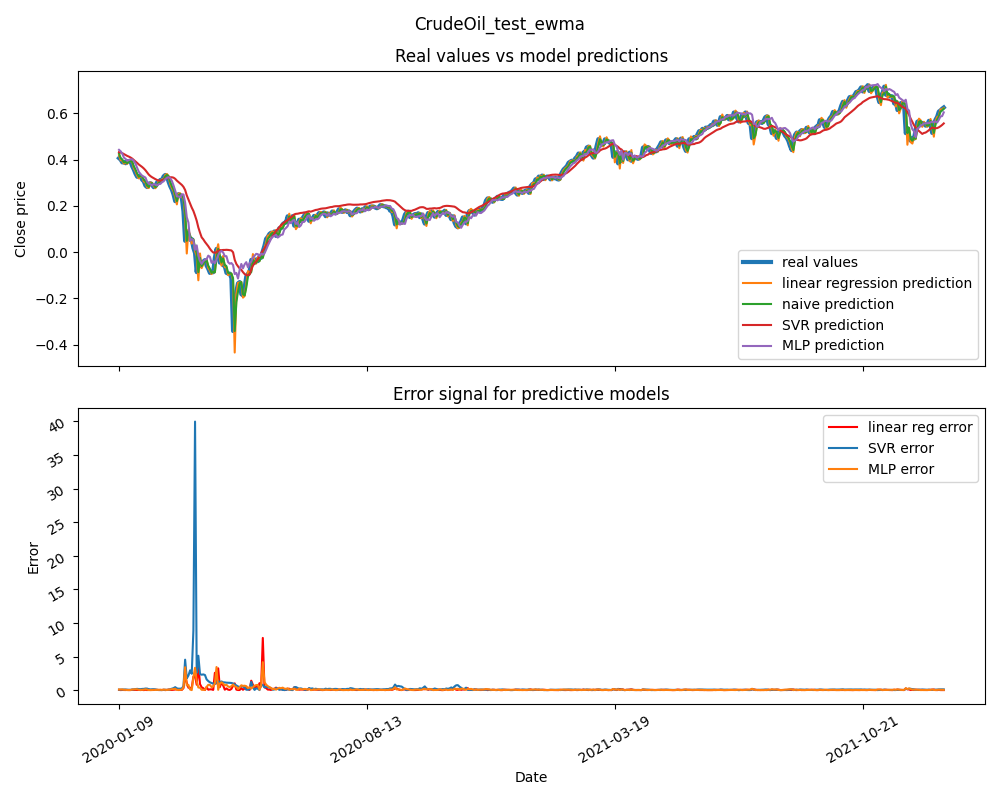

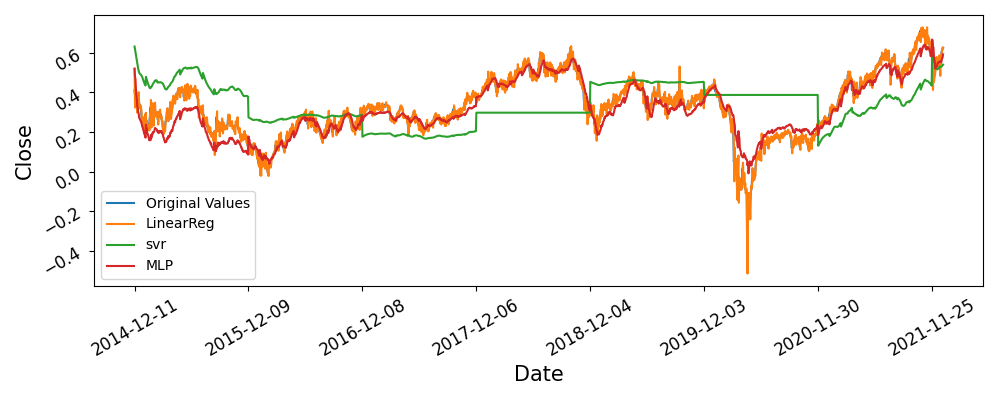

In [9]:
financial_asset = 'CrudeOil'#,'S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'test_ewma'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # smoothen data
    alpha = 0.5 # smoothing parameter
    signal = df[f'{column_to_predict}'][-2000:-split] # data
    denoised_signal = signal.ewm(alpha=alpha).mean().to_numpy()

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df['Date'][:-split], df[f'{column_to_predict}'][:-split],label='Raw signal')
    ax.plot(df['Date'][:-split], denoised_signal,label=f"EWMA_{alpha}")
    max = df.iloc[:-split,:].shape[0]
    relevant_dates = df['Date'][:-split]
    ax.set_xticks([relevant_dates.iloc[x] for x in range(0,max,150)])
    plt.legend()
    plt.tight_layout()
    display(df)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=False,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    # blah.lstm(model_tunning=False,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()

    ###################################################################################################
    # walk forward validation results
    ###################################################################################################
    mapping = {'LinearReg':blah.linear_regression_model,
                'svr':blah.svr_model,
                'MLP':blah.mlp_model#,
                # 'LSTM':blah.lstm_model
                }

    # store evaulation results for different models
    model_results = []
    model_pred_results = {'Original Values':None,
                'LinearReg':None,
                'svr':None,
                'MLP':None#,
                # 'LSTM':None,
                }

    # unfeature engineered data for walkforward
    walk_forward_input = scaler.transform(df[f'{column_to_predict}'][-2000:].to_numpy().reshape(-1,1)).flatten()

    # apply walkforward for all models
    for model_name in mapping.keys():

        # retrieve model
        model = mapping[model_name]

        # apply walk forward and save results
        train_len = 225 # 48 for Airplane
        test_len = 25   # 12 for Airplane
        df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = walk_forward_val(model_name,
                                                                            model=model,
                                                                            original_series = walk_forward_input,
                                                                            time_series_dates = df[f'Date'].iloc[-2000:],
                                                                            lag_window_length= 10,
                                                                            train_len=225,
                                                                            test_len=25,
                                                                            train_frequency=10,
                                                                            transformer=ewma_wf,
                                                                            only_training=True,
                                                                            alpha = 0.1,
                                                                            )
        # wrangle results
        
        # plots
        df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
        fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
        ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
        ax[0].set_ylabel('Close')

        ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
        ax[1].set_title('Walk forward error through time')
        ax[1].set_xlabel('Dates')
        ax[1].legend()

        max = df_walk_forward.shape[0]
        ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
        ax[1].tick_params(rotation=30)
        ax[1].set_ylabel('Error')
        ax[1].set_xlabel('Date')
        plt.tight_layout()
        plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
        plt.close()

        # tables 
        model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

        # save prediction so we can view inverted walk forward results too
        model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
        model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # place wf results into df, save to csv and latex table
    df_conclusion_wf = pd.DataFrame.from_records(model_results)
    df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
        my_latex_table.write(latex_table)

    # plot wf prediction results through time
    for model in model_pred_results.keys():
        model_pred_results[model] = model_pred_results[model].astype(float)

    model_pred_results['Date'] = df['Date'].iloc[train_len:]
    df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    ax.set_xlabel(xlabel='Date',fontsize=15)
    ax.tick_params(labelsize=12,rotation=30)

    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')
